In [1]:
%run ./imports.ipynb

# dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [2]:
path = "complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [3]:
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})

In [4]:
# lets merge the category and sub-category this will help us in deciding the topics after NMF modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)

In [5]:
df[df['complaint_text']==''] = np.nan
df = df[~df['complaint_text'].isnull()]

# text cleaning

### preprocessing

In [14]:
%run ./preprocessing.ipynb

In [13]:
data = df
data['clean'] = data['complaint_text'].apply(lambda x: preprocess(x))
# data['clean'] = data['complaint_text'].apply(lambda x: clean(x))
# data['clean'] = data['clean'].apply(lambda x: lemmatization(x))
# data['clean'] = data['clean'].apply(lambda x: spacy_clean(x))
# data['clean'] = data['clean'].str.replace('xxxx','')
# data['clean'] = data['clean'].str.replace('-PRON-', '')
pd.set_option('display.max_colwidth', None)
data.head()

NameError: name 'remove_special_characters' is not defined

In [10]:
# data=df
data['clean'] = data['complaint_text']

# Topic Modelling

### TFIDF

In [11]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
vectorizer_matrix = vectorizer.fit_transform(data['clean'])
vectorizer.get_feature_names_out()[:10]

array(['00', '000', '000s', '001', '01', '0111', '02', '03', '04', '05'],
      dtype=object)

## NMF

In [12]:
topic_num = 5
model = NMF(n_components=topic_num, random_state=42)
W = model.fit_transform(vectorizer_matrix)
H = model.components_

In [13]:
#Print the Top15 words for each of the topics
num_words=15

feature_names = np.array(vectorizer.get_feature_names_out())

top_words = lambda t: [feature_names[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H])
topics = [' '.join(t) for t in topic_words]

In [21]:
W

array([[0.04212423, 0.02209106, 0.00062661, 0.01049527, 0.01605139],
       [0.03176883, 0.00319942, 0.0611903 , 0.00705641, 0.        ],
       [0.        , 0.        , 0.0356997 , 0.04104634, 0.        ],
       ...,
       [0.01798838, 0.02435669, 0.00018282, 0.01500403, 0.00577267],
       [0.01021896, 0.01181851, 0.03480506, 0.03743666, 0.04739648],
       [0.00411371, 0.02915599, 0.00089585, 0.02348054, 0.04981238]])

In [17]:


#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ["Topic" + str(i) for i in range(model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(data['clean']))]
df_doc_topic = pd.DataFrame(np.round(W, 2), columns=colnames, index=docnames)

significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
data['Topic'] = significant_topic
df_doc_topic.head()



,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.04,0.02,0.00,0.01,0.02,0
Doc1,0.03,0.00,0.06,0.01,0.00,2
Doc2,0.00,0.00,0.04,0.04,0.00,2
Doc3,0.01,0.02,0.04,0.05,0.01,3
Doc4,0.01,0.07,0.02,0.00,0.00,1


In [173]:
data.head()

,complaint_text,category,clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection+Credit card debt,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card+General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order account anniversary date agent,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.","Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",chase card report application submit identity consent service extend credit verify identity applicant,3
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.","Credit reporting, credit repair services, or other personal consumer reports+Credit reporting",book ticket come offer ticket reward card information minute notify screen decision chase bank notification screen representative speak application state information credit offer account statement purchase ticket account ask application representative oblige application request proceed application chase fact credit account report credit report chase information credit report process application consent error,3
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 tim

In [174]:
# data.drop('Topic',axis=1,inplace=True)

In [179]:
# Print the first 10 Complaint for each of the Topics
Topics_group =data.groupby('Topic').head(10).sort_values('Topic')
Topics_group.sort_values('Topic')

,complaint_text,category,clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection+Credit card debt,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,Bank Account services
69,"Someone called stating I had felony committed under my social security number and name. Took XXXX out of my checking account to "" secure my assets "". Stating from police department.",Checking or savings account+Checking account,state felony security number check account asset state police department,Bank Account services
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,Checking or savings account+Checking account,son deposit chase account fund bank account pay money speek son money bank money son call chase time check owner country time date check number claim number chase,Bank Account services
17,"With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Post but they may take an additional business day. That Saturday I attempted to go inside of a branch yet again to retrieve my funds that actually did post on Friday, XX/XX/2019. Upon looking at my account I realize that the funds have been reversed and no longer were present on my current statement. Ive been called and I was told that it may take two business day stating Tuesday, XX/XX/XXXX would be the date that my funds would be available to withdraw from a bank teller only. Now, Chase is informing me that I will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. Unfortunately, This has put me in an additional financial bind do two fees from late rent late car payments, etc. I am not being a short or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. I am not being a shored or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. This situation is truly affecting my livelihood and they dont seem t

In [176]:
#Create the dictionary of Topic names and Topics
topic_mapping = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Mortgage/Loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others'
}
#Replace Topics with Topic Names
data['Topic'] = data['Topic'].map(topic_mapping)

<Axes: xlabel='Topic', ylabel='count'>

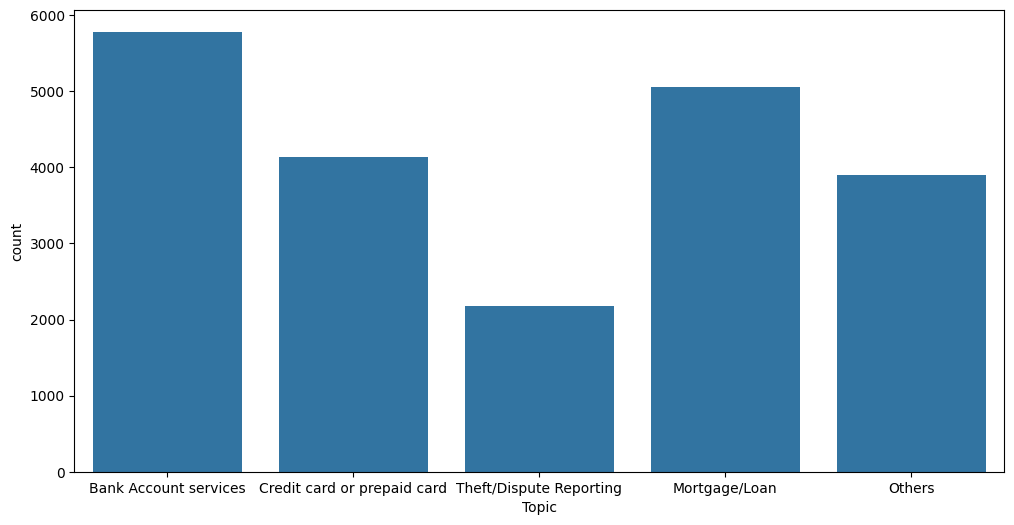

In [178]:
# Plot graph to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='Topic',data=data)

In [93]:
data.drop('Topic',axis=1,inplace=True)